# <img style="float: left; padding-right: 10px; width: 45px" src="style/iacs.png"> S-109A Introduction to Data Science 
## Homework 4 - Regularization 

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [2]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
from IPython.core.display import HTML
def css_styling():
    styles = open("style/cs109.css", "r").read()
    return HTML(styles)
css_styling()

import these libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

# from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



## Data Preparation



<div class='exercise'> <b> Question 1 </b> </div> 
  In HW3 Questions 1-3, you preprocessed the data in preparation for your regression analysis. We ask you to repeat those steps (particularly those in Question 3) so that we can compare the analysis models in this HW with those you developed in HW3.  In this HW we'll be using models from sklearn exclusively (as opposed to statsmodels)
  
**1.1** [From HW3] Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively.  Remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis.  Also remove the `casual` and `registered` columns for both training and test datasets as they make  `count` trivial.   

**1.2** Since we'll be exploring Regularization and Polynomial Features, it will make sense to standardize our data.  Standardize the numerical features. Store the dataframes for the processed training and test predictors into the variables `X_train` and `X_test`.  Store the appropriately shaped numpy arrays for the corresponding train and test `count` columns into `y_train` and `y_test`.

**1.3** Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train`.  Store the fitted model in the variable `BikeOLSModel`.

**1.4** What are the training and test set $R^2$ scores?  Store the training and test $R^2$ scores of the `BikeOLSModel` in a dictionary `BikeOLS_r2scores` using the string 'training' and 'test' as keys.  

**1.5**   We're going to use bootstrapped confidence intervals (use 500 bootstrap iterations) to determine which of the estimated coefficients for the `BikeOLSModel` are statistically significant at a significance level of 5% .  We'll do so by creating 3 different functions:

1. `make_bootstrap_sample(dataset_X, dataset_y)` returns a bootstrap sample of `dataset_X` and `dataset_y`
2. `calculate_coefficients(dataset_X, dataset_y, model)` returns in the form of a dictionary regression coefficients calculated by your model on `dataset_X` and `dataset_y`.  The keys for regression coefficients dictionary should be the names of the features.  The values should be the coefficient values of that feature calculated on your model.  An example would be {'hum': 12.3, 'windspeed': -1.2, 'Sunday': 0.6 ... }
3. `get_significant_predictors(regression_coefficients, significance_level)` takes as input a list of regression coefficient dictionaries (each one the output of `calculate_coefficients` and  returns a python list of the feature names of the significant predictors e.g. ['Monday', 'hum', 'holiday', ... ]

In the above functions `dataset_X` should always be a pandas dataframe with your features, `dataset_y` a numpy column vector with the values of the response variable and collectively they form the dataset upon which the operations take place. `model` is the `sklearn` regression model that will be used to generate the regression coefficients. `regression_coefficients` is a list of dictionaries of numpy arrays with each numpy array containing the regression coefficients (not including the intercept) calculated from one bootstrap sample.  `significance_level` represents the significance level as a floating point number.  So a 5% significance level should be represented as 0.05.  


Store the feature names as a list of strings in the variable `BikeOLS_significant_bootstrap` and print them for your answer.


### Answers

#### 1.1 Read `data/BSS_train.csv` and `data/BSS_test.csv` into Pandas DataFrames

In [14]:
# your code here
BSS_train = pd.read_csv('data/BSS_train.csv').drop(["Unnamed: 0",'dteday','casual','registered'],axis=1)
BSS_test = pd.read_csv('data/BSS_test.csv').drop(["Unnamed: 0",'dteday','casual','registered'],axis=1)

#### 1.2 Standardizing our data

In [208]:
# your code here
X_train = BSS_train.drop('counts',axis=1)
y_train = np.array(BSS_train['counts']).reshape(-1,1)
X_test = BSS_test.drop('counts',axis=1)
y_test = np.array(BSS_test['counts']).reshape(-1,1)

num = ['hour','temp','atemp','hum','windspeed']
scaler = StandardScaler().fit(X_train[num])
X_train[num] = scaler.transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

#### 1.3 Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression.

In [159]:
# your code here
BikeOLSModel = LinearRegression(fit_intercept=True).fit(X_train, y_train)

#### 1.4 What are the training and test set $R^2$ scores? Store the $R^2$ scores of the `BikeOLSModel` on the training and test sets in a dictionary `BikeOLS_r2scores`. 

In [160]:
y_pred = BikeOLSModel.predict(X_test)
r2_test = r2_score(y_test,y_pred)
r2_train = r2_score(y_train,BikeOLSModel.predict(X_train))
BikeOLS_r2scores = {'training': r2_train,'test':r2_test}
BikeOLS_r2scores

{'training': 0.4065387827969087, 'test': 0.40638554757102285}

#### 1.5 We're going to use bootstrapped confidence intervals to determine which of the estimated coefficients ...

In [269]:
# References: https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/
#             https://en.wikipedia.org/wiki/Ordinary_least_squares#Finite_sample_properties
from scipy.stats import t,sem,ttest_ind,ttest_rel

# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    
    
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
        
    df = pd.concat([dataset_X,pd.DataFrame(dataset_y,columns = ['y'])],axis=1)
    bs_df = df.sample(n=size,replace=True,axis=0)
    
    bootstrap_dataset_X = bs_df.loc[:,dataset_X.columns]
#     bs_df = df.sample(n=size,replace=True,axis=0)
    bootstrap_dataset_y = np.array(bs_df.y).reshape(-1,1)
    
    # return as a tuple your bootstrap samples of dataset_X as a pandas dataframe
    # and your bootstrap samples of dataset y as a numpy column vector
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    
    # your code here
    
    ols = model.fit(dataset_X,dataset_y)
    coefficients_dictionary = {}
    for i,param in enumerate(dataset_X.columns):
        coefficients_dictionary[param] = ols.coef_[0][i]
        
    # return coefficients  in the variable  coefficients_dictioanry as a dictionary
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # do not return the intercept as part of this
    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, significance_level):
   
    significant_coefficients = []
    n = len(X_train)
    
    coefs = regression_coefficients[0]
    for param in regression_coefficients[0].keys():
        boot_sample = np.array([k[param] for k in regression_coefficients])
        mean = boot_sample.mean()
        s = boot_sample.std()
        t_stat = mean/s
        p = (1-t.cdf(abs(t_stat), n-2))*2
        if p<significance_level:
            significant_coefficients.append(param)
    
    # regression_coefficients is a list of dictionaries
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # each dictionary in th list should be the output of calculate_coefficients
    
    
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [271]:
coef_list = []
for _ in range(500):
    x_bs,y_bs = make_bootstrap_sample(X_train,y_train)
    coef = calculate_coefficients(x_bs, y_bs, LinearRegression())
    coef_list.append(coef)
BikeOLS_significant_bootstrap = get_significant_predictors(coef_list, 0.05)
print(BikeOLS_significant_bootstrap)
len(BikeOLS_significant_bootstrap)

['hour', 'year', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Nov', 'Dec', 'Sat', 'Cloudy', 'Snow']


19

## Penalization Methods

In HW 3 Question 5 we explored using subset selection to find a significant subset of features.  We then fit a regression model just on that subset of features instead of on the full dataset (including all features).   As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

<div class='exercise'> <b> Question 2 </b> </div> 
  We're going to use Ridge and Lasso regression regularization techniques to fit linear models to the training set.  We'll use cross-validation and shrinkage parameters $\lambda$ from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ to pick the best model for each regularization technique.

**2.1** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model on the training data.  Fit a Ridge Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeRRModel`.  Store the selected shrinkage parameter in the variable `BikeRR_shrinkage_parameter`.

**2.2** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model on the training data.  Fit a Lasso Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeLRModel`.  Store the selected shrinkage parameter in the variable `BikeLR_shrinkage_parameter`.

**2.3** Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients for each of the regression models indexed by the string feature name.

**2.4** For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 (i.e. the absolute value of the coefficient is less than 0.1).  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

**2.5** To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).  Plot a bar graph of the magnitude (absolute value) of the estimated coefficients from Multiple Linear Regression in order from greatest to least.  Using a different color (and alpha values) overlay bar graphs of the magnitude of the estimated coefficients (in the same order as the Multiple Linear Regression coefficients) from Ridge and Lasso Regression.

**2.6** Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

**2.7** Discuss the Results:

1. How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1? 
2. Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
3. Is the significance related to the shrinkage in some way?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values.

### Answers

In [15]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

#### 2.1 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model.

In [16]:
# your code here
ridge_reg = RidgeCV(alphas=lambdas,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
BikeRR_shrinkage_parameter = ridge_reg.alpha_
BikeRRModel = Ridge(alpha = BikeRR_shrinkage_parameter).fit(X_train,y_train)
BikeRRModel#.score(X_train,y_train)

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

#### 2.2 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model.

In [17]:
# your code here
lasso_reg = LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)
BikeLR_shrinkage_parameter = lasso_reg.alpha_
BikeLRModel = Lasso(alpha = BikeLR_shrinkage_parameter).fit(X_train,y_train)
# BikeLRModel = Lasso(alpha = 50).fit(X_train,y_train)
BikeLRModel#.score(X_train,y_train)

Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

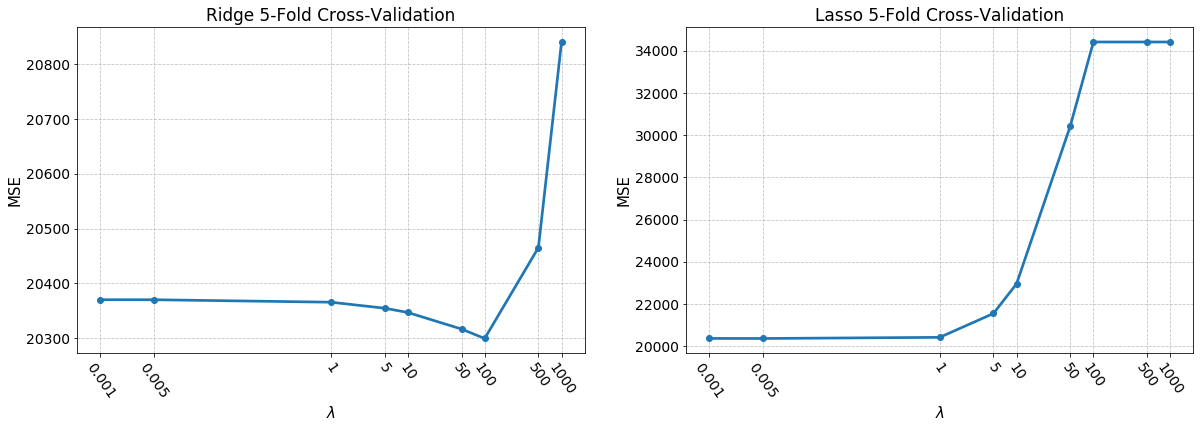

In [51]:
#Manually imlementing cross-validation for visualization
kf = KFold(n_splits=5)
MSE_ridge = []
MSE_lasso = []

lambda_r = 0 #best lambda for ridge
lambda_l = 0 #best lambda for lasso

score_r = -np.inf #for ridge
score_l = -np.inf #for lasso

for l in lambdas:
    ridge_reg = Ridge(alpha=l)
    lasso_reg = Lasso(alpha=l)
    
    neg_MSE_ridge = cross_val_score(ridge_reg, X_train, y_train, cv=kf,scoring='neg_mean_squared_error')
    neg_MSE_lasso = cross_val_score(lasso_reg, X_train, y_train, cv=kf,scoring='neg_mean_squared_error')
    
    MSE_ridge.append(-neg_MSE_ridge.mean())
    MSE_lasso.append(-neg_MSE_lasso.mean())
    
    if neg_MSE_ridge.mean() > score_r:
        score_r = neg_MSE_ridge.mean()
        lambda_r = l
    if neg_MSE_lasso.mean() > score_l:
        score_l = neg_MSE_lasso.mean()
        lambda_l = l

#Plotting commands
fig,ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(np.log(lambdas),MSE_ridge,'-o',lw=2.7)
ax[0].set_xticks(np.log(lambdas))
ax[0].set_xticklabels(lambdas,rotation=-55,fontsize=14);
ax[0].tick_params(axis="y", labelsize=14)
ax[0].set_title("Ridge 5-Fold Cross-Validation",fontsize=17)
ax[0].set_xlabel("$\lambda$",fontsize=15)
ax[0].set_ylabel("MSE",fontsize=15)
ax[0].grid(True,alpha=0.75,ls='--')

ax[1].plot(np.log(lambdas),MSE_lasso,'-o',lw=2.7)
ax[1].set_xticks(np.log(lambdas))
ax[1].set_xticklabels(lambdas,rotation=-55,fontsize=14);
ax[1].tick_params(axis="y", labelsize=14)
ax[1].set_title("Lasso 5-Fold Cross-Validation",fontsize=17)
ax[1].set_xlabel("$\lambda$",fontsize=15)
ax[1].set_ylabel("MSE",fontsize=15)
ax[1].grid(True,alpha=0.75,ls='--')


#### 2.3 Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients.

In [52]:
# your code here
BikeOLSparams = {}
BikeLRparams = {}
BikeRRparams = {}
for i,param in enumerate(X_train.columns):
    BikeOLSparams[param] = BikeOLSModel.coef_[0][i]
    BikeLRparams[param] = BikeLRModel.coef_[i]
    BikeRRparams[param] = BikeRRModel.coef_[0][i]

#### 2.4 For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 ...

In [53]:
# your code here
zero_lasso = []
zero_ridge = []
for param in X_train.columns:
    if abs(BikeLRparams[param])<0.1:
        zero_lasso.append(param)
    if abs(BikeRRparams[param])<0.1:
        zero_ridge.append(param)
print("Lasso Zeroed features: {}".format(zero_lasso))
print("Ridge Zeroed features: {}".format(zero_ridge))

Lasso Zeroed features: ['Mon']
Ridge Zeroed features: []


<HR>
 In HW3 Question 5, our stepwise selection algorithm selected the following predictors:
    
 - 'temp', 'hour', 'year', 'hum', 'fall', 'Jul', 'Snow', 'Aug', 'Jun', 'holiday',
'spring'

The Lasso Regression ($\lambda=0.005$) zeroed just the 'Mon' feature and the Ridge ($\lambda = 100$) maintained all predictors in the model
<HR>

#### 2.5 To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).

,OLS,Lasso,Ridge
temp,64.214408,63.832847,48.492270
atemp,12.832458,12.868765,23.343775


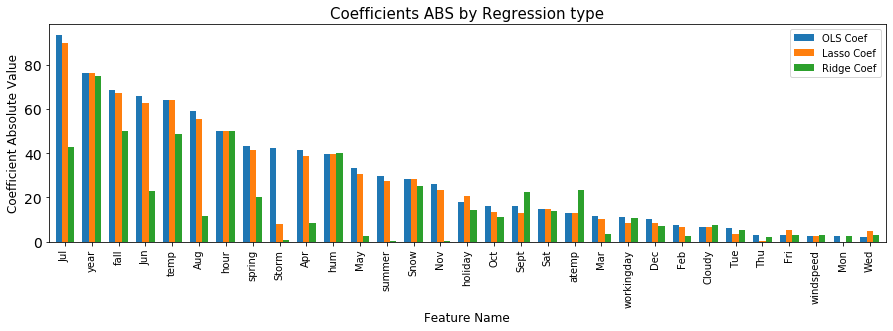

In [61]:
ols = pd.DataFrame.from_dict(BikeOLSparams,orient='index',
    columns=['OLS Coef']).apply(np.abs).sort_values(by='OLS Coef',ascending=0)
lr = pd.DataFrame.from_dict(BikeLRparams,orient='index',
    columns=['Lasso Coef']).apply(np.abs)
rr = pd.DataFrame.from_dict(BikeRRparams,orient='index',
    columns=['Ridge Coef']).apply(np.abs)

fig,ax = plt.subplots(1,1,figsize=(15,4))
ax.set_title("Coefficients ABS by Regression type",fontsize=15)
ax.set_xlabel("Feature Name",fontsize=12)
ax.set_ylabel("Coefficient Absolute Value",fontsize=12)
pd.concat([ols,lr,rr],axis=1).plot.bar(ax=ax,width=0.7);

pd.DataFrame(np.array([[BikeOLSparams['temp'],BikeLRparams['temp'],BikeRRparams['temp']],
                      [BikeOLSparams['atemp'],BikeLRparams['atemp'],BikeRRparams['atemp']]]),
             columns = ['OLS','Lasso','Ridge'],index = ['temp','atemp'])

#### 2.6 Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients ...v

<HR>
The Lasso coefficients for temp and atemp were very similar (slightly lower) to the original OLS ones, that's because the regularization parameter is quite low ($\lambda = 0.005$).
    
But analyzing Ridge Regression, we had a lower temp coefficient and a higher atemp coefficient (comparing to Lasso) as we can see above.
    
Since temp has that higher magnitude coefficients, both regularization methods penalized it. Lasso decreased it just a litle bit as explained, but Ridge decreased it by almost half. Since its an important feature to the model, such a reduction would damage the scoring metrics; The ajust made by the model was an increase, doubling the atemp coefficient, since it's extremely related to temp. The overall L2-norm of these coefficients on Ridge regression is lower than the L2-norm of simple OLS, as we can see.
<HR>

In [55]:
print("OLS Norm: {:.2f}".format(np.sqrt(BikeOLSparams['temp']**2+BikeOLSparams['atemp']**2)))
print("Ridge Norm: {:.2f}".format(np.sqrt(BikeRRparams['temp']**2+BikeRRparams['atemp']**2)))

OLS Norm: 65.48
Ridge Norm: 53.82


#### 2.7.1 How do the estimated coefficients compare to or differ from ...

<HR>
In the plot titled "Coefficients ABS by Regression type", we can see that the greatest coefficients (by absolute value) in OLS regression got shrink by the regularized regressions.
    
We can say that this happened with all features, except for some with low absolute coefficients value in OLS regression when the regularized model increase the value. But overall, the regularized coefficients got its module shrank.
<HR>

#### 2.7.2 Is there a difference between coefficients estimated by the two shrinkage methods ...

<HR>
As briefly explained in 2.6, the Lasso Regression coefficients are very close to the original ones, because of the optimal lambda parameter .005.
    
Ridge Regression coefficients differs a lot from the Lasso ones (and OLS ones) because it shrank the most "heavy" coefficients on the original model and compensates the loss in regression score by increasing coefficients originally with the low module. Ridge does that in order to optimize the L2-norm of coefficients.
<HR>

#### 2.7.3 Is the significance related to the shrinkage in some way?

<HR>
We can observe either statistically significant coefficients didn't get shrink too much by Ridge and also those who really got shrink (we're analyzing just Ridge 'cause Lasso shrinkage is very little).
    
It isn't directly connected with significance because Ridge will try to optimize the L2-norm rebalancing the values of the coefficients. The side effect is that it can increase coefficients values of not significant features and decreases the significant ones, as we can visualize below.
<HR>

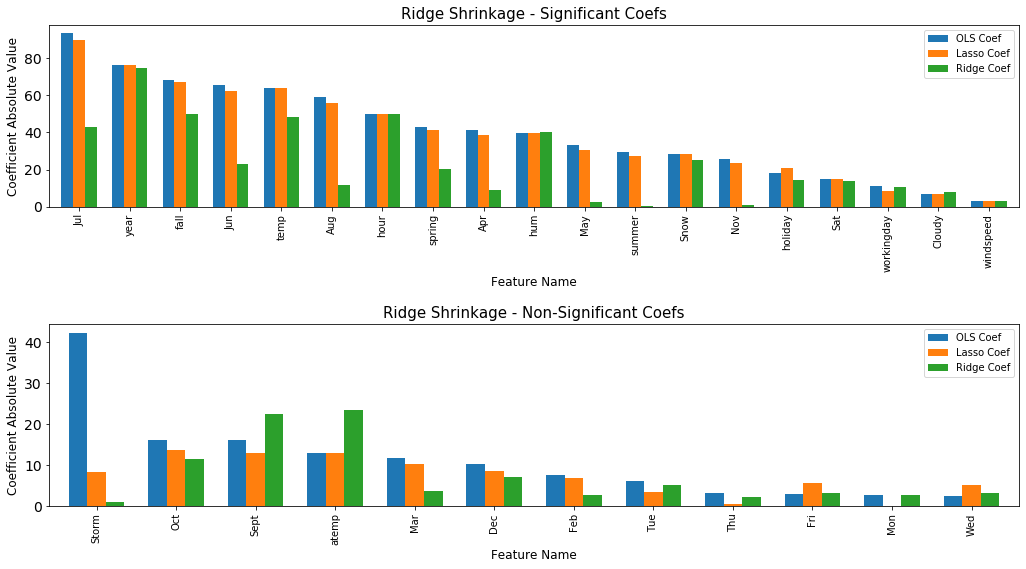

In [99]:
sig = ['hour','holiday','year','workingday','temp','hum','windspeed','spring','summer',
       'fall','Apr','May','Jun','Jul','Aug','Nov','Sat','Cloudy','Snow'] #From hw3

fig,(ax,ax1) = plt.subplots(2,1,figsize=(15,8))
ax.set_title("Ridge Shrinkage - Significant Coefs",fontsize=15)
ax.set_xlabel("Feature Name",fontsize=12)
ax.set_ylabel("Coefficient Absolute Value",fontsize=12)
pd.concat([ols,lr,rr],axis=1).loc[sig,:].sort_values(by="OLS Coef",ascending=0).plot.bar(ax=ax,width=0.7);

fig.tight_layout(pad=3.0)

ax1.set_title("Ridge Shrinkage - Non-Significant Coefs",fontsize=15)
ax1.set_xlabel("Feature Name",fontsize=12)
ax1.set_ylabel("Coefficient Absolute Value",fontsize=12)
pd.concat([ols,lr,rr],axis=1).loc[ols.index.drop(sig),:].sort_values(by="OLS Coef",ascending=0).plot.bar(ax=ax1,width=0.7);


<div class='exercise'> <b> Question 3: Polynomial Features, Interaction Terms, and Cross Validation </b> </div>


We would like to fit a model to include all main effects and polynomial terms for numerical predictors up to the $4^{th}$ order. More precisely use the following terms: 
 - predictors in `X_train` and `X_test`
 - $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ for each numerical predictor $X_j$

**3.1** Create an expanded training set including all the desired terms mentioned above. Store that training set (as a pandas dataframe) in the variable `X_train_poly`.  Create the corresponding test set and store it as a pandas dataframe in `X_test_poly`.

**3.2** Discuss the following:

1. What are the dimensions of this 'design matrix' of all the predictor variables in 3.1?  
2. What issues may we run into attempting to fit a regression model using all of these predictors?

**3.3** Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train_poly`.  Store the fitted model in the variable `BikeOLSPolyModel`.

**3.4** Discuss the following:
1. What are the training and test $R^2$ scores? 
2. How does the model performance compare with the OLS model on the original set of features in Question 1?

**3.5** The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample sets of $R^2$ for our model. Use 5-fold cross-validation to generate $R^2$ scores for the multiple linear regression model with polynomial terms.  What are the mean and standard deviation of the $R^2$ scores for your model.

**3.6** Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

**3.7** We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives:

1. Multiple linear regression model generated based upon the feature set in Question 1 (let's call these the base features.
2. base features plus polynomial features to order 2
3. base features plus polynomial features to order 4

Use 5-fold cross validation on the training set to select the best model.  Make sure to evaluate all the models as much as possible on the same folds.  For each model generate a mean and standard deviation for the $R^2$ score.

**3.8** Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

**3.9** Evaluate each of the model alternatives on the test set.  How do the results compare with the results from cross-validation?

### Answers

#### 3.1 Create an expanded training set including all the desired terms mentioned above. Store that training set (as a numpy array) in the variable `X_train_poly`....

In [101]:
# Reference: CS109A - Standard Section 4: Regularization and Model Selection

def cross_names(cols):
    names = []
    for i in range(len(cols)):
        [names.append(x) for x in ["{} x {}".format(cols[i],cols[j]) for j in range(i+1,len(cols))]]
    return names

def get_poly_dataset(X_train,X_test,n,num = ['hour','temp','atemp','hum','windspeed']):
   
    xtrain_cp = X_train.copy()
    xtest_cp = X_test.copy()
    for param in num:
        for i in range(2,n+1):
            xtrain_cp["{}^{}".format(param,i)] = xtrain_cp[param]**i
            xtest_cp["{}^{}".format(param,i)] = xtest_cp[param]**i
    return (xtrain_cp,xtest_cp)

In [102]:
X_poly_train, X_poly_test = get_poly_dataset(X_train, X_test, 4)
X_poly_train.shape

(13903, 46)

#### 3.2.1 What are the dimensions of this 'design matrix'...**

<HR>
 The training X matrix has the dimensions 13903 x 46 (without constant column) and 13903 x 47 (if we add the constant column)
<HR>

#### 3.2.2 What issues may we run into attempting to fit a regression model using all of these predictors? ...**

<HR>
Increasing the model complexity we're gonna reduce bias, with the trade-off of increasing the variance and then, the total error. We can also overfit the model to the training set.
<HR>

#### 3.3 Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model ....

In [103]:
BikeOLSPolyModel = LinearRegression()
BikeOLSPolyModel.fit(X_poly_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### 3.4.1 What are the training and test $R^2$ scores?

In [105]:
# your code here
y_train_pred = BikeOLSPolyModel.predict(X_poly_train)
y_test_pred = BikeOLSPolyModel.predict(X_poly_test)

print("Training R2: {:.6f}\nTest R2: {:.6f}".format(r2_score(y_train,y_train_pred),
                                                    r2_score(y_test,y_test_pred)))

Training R2: 0.555313
Test R2: 0.551873


#### 3.4.2 How does the model performance compare with the OLS model on the original set of features in Question 1?

In [106]:
BikeOLS_r2scores

{'training': 0.4065387827969087, 'test': 0.40638554757102285}

<HR>
Comparing to Question 1 scores, we got better R2 scores overall.
<HR>

#### 3.5 The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample...

In [110]:
r2 = cross_val_score(LinearRegression(), X_poly_train, y_train, cv=KFold(n_splits=5),scoring='r2')
print("Mean = {:.4f}".format(r2.mean()))
print("Std. dev. = {:.4f}".format(r2.std()))

Mean = 0.3986
Std. dev. = 0.1297


<HR>
We got a mean of $\approx 0.3986$ and a standard deviation of $\approx 0.1297$
<HR>

#### 3.6 Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

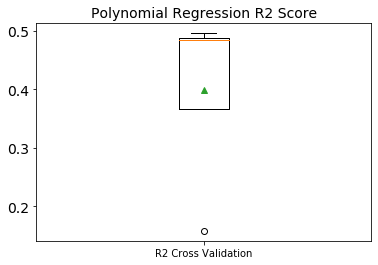

In [112]:
plt.title("Polynomial Regression R2 Score",fontsize=14)
plt.boxplot(r2, labels=["R2 Cross Validation"],showmeans=True);

#### 3.7 We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives ...

In [113]:
X_deg2_train,X_deg2_test = get_poly_dataset(X_train,X_test,2)
X_deg4_train,X_deg4_test = get_poly_dataset(X_train,X_test,4)

kf = KFold(n_splits=5)
model1_r2 = cross_val_score(LinearRegression(), X_train, y_train, cv=kf, scoring='r2')
model2_r2 = cross_val_score(LinearRegression(), X_deg2_train, y_train, cv=kf, scoring='r2')
model3_r2 = cross_val_score(LinearRegression(), X_deg4_train, y_train, cv=kf, scoring='r2')

r2_df = pd.DataFrame(np.array([[model1_r2.mean(),model2_r2.mean(),model3_r2.mean()],
                       [model1_r2.std(),model2_r2.std(),model3_r2.std()]]),
             index=['Mean','Std'],columns=["Model 1 R²","Model 2 R²","Model 3 R²"])
r2_df

,Model 1 R²,Model 2 R²,Model 3 R²
Mean,0.257994,0.355123,0.398601
Std,0.092201,0.096739,0.129711


#### 3.8 Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best? ...

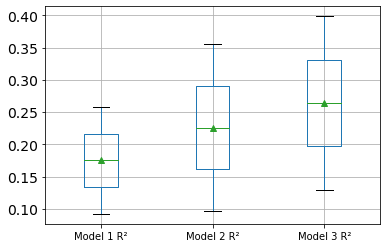

In [114]:
# your code here
r2_df.boxplot(showmeans=True,grid=1);

The plot influence us to think that the third model is the best, since it got a higher R2 distribution.

#### 3.9 Evaluate each of the model alternatives on the  test set.  How do the results compare with the results from cross-validation?

In [115]:
# your code here
model1 = LinearRegression().fit(X_train,y_train)
model2 = LinearRegression().fit(X_deg2_train,y_train)
model3 = LinearRegression().fit(X_deg4_train,y_train)

y1_pred = model1.predict(X_test)
y2_pred = model2.predict(X_deg2_test)
y3_pred = model3.predict(X_deg4_test)

r2test1 = r2_score(y_test,y1_pred)
r2test2 = r2_score(y_test,y2_pred)
r2test3 = r2_score(y_test,y3_pred)
r2test1,r2test2,r2test3

(0.40638554757102285, 0.49794171765518735, 0.5518725502376848)

<HR>
Model 3 (Polynomial 4th degree) is still the best one; comparing now the test R2 score.
<HR>

In [2]:
!jupyter nbconvert --execute --to PDF "fds_hw4_RENER_OLIVEIRA.ipynb"

[NbConvertApp] Converting notebook fds_hw4_RENER_OLIVEIRA.ipynb to PDF
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Support files will be in fds_hw4_RENER_OLIVEIRA_files/
[NbConvertApp] Making directory ./fds_hw4_RENER_OLIVEIRA_files
[NbConvertApp] Making directory ./fds_hw4_RENER_OLIVEIRA_files
[NbConvertApp] Making directory ./fds_hw4_RENER_OLIVEIRA_files
[NbConvertApp] Making directory ./fds_hw4_RENER_OLIVEIRA_files
[NbConvertApp] Making directory ./fds_hw4_RENER_OLIVEIRA_files
[NbConvertApp] Writing 102060 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 220700 bytes to fds_hw4_RENER_OLIVEIRA.pdf
